<a href="https://colab.research.google.com/github/AwareTeam-LOD/chore-finals/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22AwareTeam_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Давайте скачаем вначале предоставленные нам данные (датапак), с которым мы и будем работать в дальнейшем. 

> Я загрузил его на свой сервер, чтобы получить прямую ссылку на файл (иначе не получится скачать данные с wget).



In [1]:
!wget https://test.deqstudio.com/datapack.zip -P datas/
!unzip datas/datapack.zip -d datas/

--2022-01-29 14:30:35--  https://test.deqstudio.com/datapack.zip
Resolving test.deqstudio.com (test.deqstudio.com)... 78.46.109.73
Connecting to test.deqstudio.com (test.deqstudio.com)|78.46.109.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2158896 (2.1M) [application/zip]
Saving to: ‘datas/datapack.zip’

datapack.zip        100%[===================>]   2.06M  2.07MB/s    in 1.0s    

2022-01-29 14:30:37 (2.07 MB/s) - ‘datas/datapack.zip’ saved [2158896/2158896]

Archive:  datas/datapack.zip
 extracting: datas/01_all_users.csv  
 extracting: datas/02_events_log.csv  
 extracting: datas/03_lk_events_log.csv  
 extracting: datas/04_is_blocked.csv  
 extracting: datas/test.csv          


Давайте установим зависимости и нужные штучки, а так же загрузим датасеты

In [2]:
!pip install pandas numpy keras tensorflow

#Стандартные библиотеки для аналитики данных:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm, skew
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

# sklearn модули для предпроцессинга данных:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#sklearn модули для Model Selection: 
from sklearn import svm, tree, linear_model, neighbors
from sklearn import naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#sklearn модули для эволюции и улучшения моделей:
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.metrics import f1_score, precision_score, recall_score, fbeta_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import make_scorer, recall_score, log_loss
from sklearn.metrics import average_precision_score

#Стандартные библиотки для визуализации данных:
import seaborn as sn
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib 
%matplotlib inline
color = sn.color_palette()
import matplotlib.ticker as mtick
from IPython.display import display
pd.options.display.max_columns = None
from pandas.plotting import scatter_matrix
from sklearn.metrics import roc_curve

#Различные библиотки утилит:
import random
import os
import re
import sys
import timeit
import string
import time
from datetime import datetime
from time import time
from dateutil.parser import parse
import joblib

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Загрузка и обработка материалов
Теперь загрузим в программу наши наборы данных.

In [3]:
datas_all_users = pd.read_csv('datas/01_all_users.csv')
datas_events_log = pd.read_csv('datas/02_events_log.csv')
datas_lk_events = pd.read_csv('datas/03_lk_events_log.csv')
datas_is_blocked = pd.read_csv('datas/04_is_blocked.csv')

Наш датасет изначально разбит на несколько файлов (01_all_users.csv, 02_events_log, 03_lk_events_log, 04_is_blocked). Давайте объединим их в один датафрейм. Признак для объединения - contract_id (по нему мы идентифицируем строки для объединения).

In [4]:
pd.concat((datas_events_log, datas_is_blocked), axis = 1)
datas_merged = pd.merge(datas_events_log, datas_is_blocked, on=('contract_id'))
datas_merged = pd.merge(datas_merged, datas_lk_events, on=('contract_id'))
datas_merged = pd.merge(datas_merged, datas_all_users, on=('contract_id'))
datas_merged

,contract_id,event_date_x,event_type,blocked,event_date_y,name,day_or_month_contract
0,33846,2021-04-03 19:09:26,Добавление в Обращались с номеров,1,2021-03-19 15:12:52,Информер ВК. Показ,0
1,33846,2021-04-03 19:09:26,Добавление в Обращались с номеров,1,2021-03-27 18:46:04,Информер ВК. Показ,0
2,33846,2021-04-03 19:09:26,Добавление в Обращались с номеров,1,2021-04-03 18:55:22,Информер ВК. Показ,0
3,33846,2021-04-08 10:59:48,Отключение услуги Аренда ТВ-приставки,1,2021-03-19 15:12:52,Информер ВК. Показ,0
4,33846,2021-04-08 10:59:48,Отключение услуги Аренда ТВ-приставки,1,2021-03-27 18:46:04,Информер ВК. Показ,0
...,...,...,...,...,...,...,...
36801,5023,2021-03-19 17:58:07,Манипуляции с оборудованием,0,2021-04-27 21:27:12,Информер ВК. Показ,0
36802,5023,2021-03-19 17:58:07,Манипуляции с оборудованием,0,2021-04-27 21:27:31,Включение IPTV-пакета,0
36803,5023,2021-03-19 17:58:07,Манипуляции с оборудованием,0,2021-04-28 20:26:50,Включение интернета на 20 минут,0
36804,5023,2021-03-19 17:58:07,Манипуляции с оборудованием,0,2021-04-28 20:32:05,Информер ВК. Показ,0


Давайте уберем из датасета колонку contract_id, чтобы она не мешалась при обучении. Однако, мы ее сохраним в test_identity, чтобы обратиться к ней позднее.
Так же, мы полностью удалим колонки event_date_x, event_date_y, поскольку они не пригодятся в обучении.

In [5]:
test_identity = datas_merged['contract_id'] #копируем колонку contract_id в переменную test_identity, а на строке ниже - удаляем ее из основного датасета
datas_merged = datas_merged.drop(['event_date_x', 'event_date_y', 'contract_id'], axis=1)
datas_merged

,event_type,blocked,name,day_or_month_contract
0,Добавление в Обращались с номеров,1,Информер ВК. Показ,0
1,Добавление в Обращались с номеров,1,Информер ВК. Показ,0
2,Добавление в Обращались с номеров,1,Информер ВК. Показ,0
3,Отключение услуги Аренда ТВ-приставки,1,Информер ВК. Показ,0
4,Отключение услуги Аренда ТВ-приставки,1,Информер ВК. Показ,0
...,...,...,...,...
36801,Манипуляции с оборудованием,0,Информер ВК. Показ,0
36802,Манипуляции с оборудованием,0,Включение IPTV-пакета,0
36803,Манипуляции с оборудованием,0,Включение интернета на 20 минут,0
36804,Манипуляции с оборудованием,0,Информер ВК. Показ,0


Давайте создадим график. Однако, у нас слишком уж много значений в полях, поэтому график разглядет сложно; но, можно ориентироваться на цвета (чем темнее - тем более часто оно встречается):

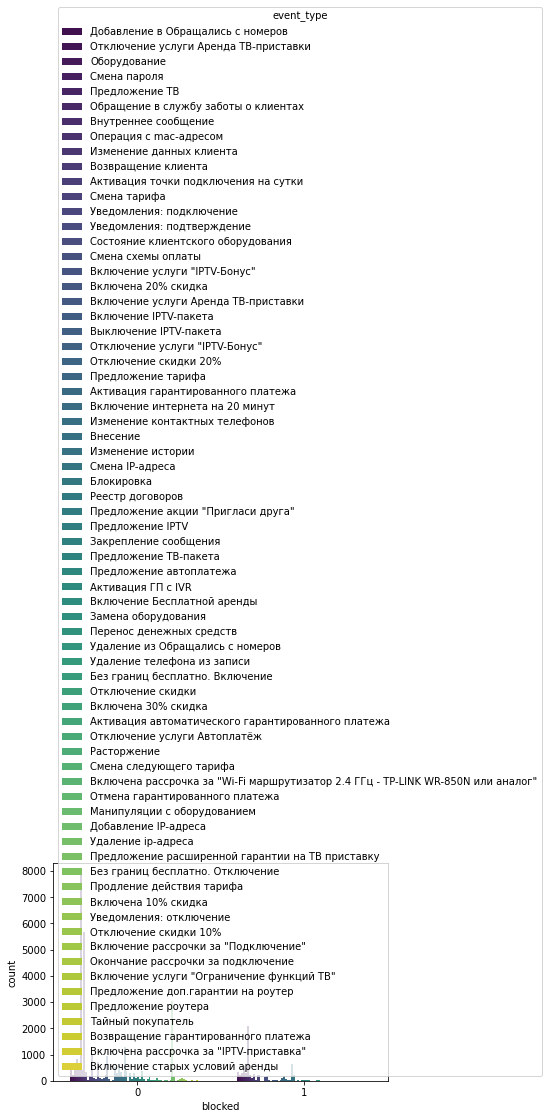

In [6]:
sns.countplot(x='blocked',data=datas_merged, hue='event_type',palette='viridis')

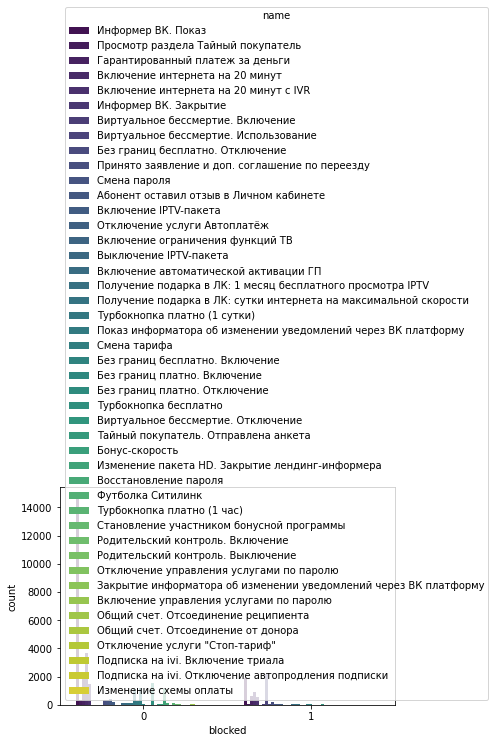

In [7]:
sns.countplot(x='blocked',data=datas_merged, hue='name',palette='viridis')

Большая проблема в том, что данные о действиях клиента представлены в текстовом формате, ими обучить модель не получится. Нам необходимо перевести их в челочисленный вид. Для этого мы создадим "словарь", где каждому возможному типу события присвоим номер.
Вначале для колонки event_type:

In [8]:
original_copied = datas_copy = datas_merged
datas_merged_temp = datas_merged
event_type_list = datas_merged.event_type.unique()
exist_events = dict(zip(event_type_list, range(len(event_type_list))))
datas_merged = datas_merged_temp
exist_events

{'Активация ГП с IVR': 37,
 'Активация автоматического гарантированного платежа': 46,
 'Активация гарантированного платежа': 24,
 'Активация точки подключения на сутки': 10,
 'Без границ бесплатно. Включение': 43,
 'Без границ бесплатно. Отключение': 56,
 'Блокировка': 30,
 'Включена 10% скидка': 58,
 'Включена 20% скидка': 17,
 'Включена 30% скидка': 45,
 'Включена рассрочка за "IPTV-приставка"': 68,
 'Включена рассрочка за "Wi-Fi маршрутизатор 2.4 ГГц - TP-LINK WR-850N или аналог"': 50,
 'Включение IPTV-пакета': 19,
 'Включение Бесплатной аренды': 38,
 'Включение интернета на 20 минут': 25,
 'Включение рассрочки за "Подключение"': 61,
 'Включение старых условий аренды': 69,
 'Включение услуги "IPTV-Бонус"': 16,
 'Включение услуги "Ограничение функций ТВ"': 63,
 'Включение услуги Аренда ТВ-приставки': 18,
 'Внесение': 27,
 'Внутреннее сообщение': 6,
 'Возвращение гарантированного платежа': 67,
 'Возвращение клиента': 9,
 'Выключение IPTV-пакета': 20,
 'Добавление IP-адреса': 53,
 'Доб

Теперь тоже самое для колонки name:

In [9]:
original_copied_2 = original_copied
datas_merged_temp = original_copied
name_list = original_copied.name.unique()
exist_named = dict(zip(name_list, range(len(name_list)+1)))
datas_merged = datas_merged_temp
exist_named

{'Абонент оставил отзыв в Личном кабинете': 11,
 'Без границ бесплатно. Включение': 22,
 'Без границ бесплатно. Отключение': 8,
 'Без границ платно. Включение': 23,
 'Без границ платно. Отключение': 24,
 'Бонус-скорость': 28,
 'Виртуальное бессмертие. Включение': 6,
 'Виртуальное бессмертие. Использование': 7,
 'Виртуальное бессмертие. Отключение': 26,
 'Включение IPTV-пакета': 12,
 'Включение автоматической активации ГП': 16,
 'Включение интернета на 20 минут': 3,
 'Включение интернета на 20 минут с IVR': 4,
 'Включение ограничения функций ТВ': 14,
 'Включение управления услугами по паролю': 38,
 'Восстановление пароля': 30,
 'Выключение IPTV-пакета': 15,
 'Гарантированный платеж за деньги': 2,
 'Закрытие информатора об изменении уведомлений через ВК платформу': 37,
 'Изменение пакета HD. Закрытие лендинг-информера': 29,
 'Изменение схемы оплаты': 44,
 'Информер ВК. Закрытие': 5,
 'Информер ВК. Показ': 0,
 'Общий счет. Отсоединение от донора': 40,
 'Общий счет. Отсоединение реципиента

Словарь значений готов.

Теперь в самом датапаке изменим текстовые значения на целочисленные, согласно словарю:

In [10]:
datas_copy['event_type'] = datas_copy['event_type'].map(exist_events)
datas_copy['name'] = datas_copy['name'].map(exist_named)
datas_copy

,event_type,blocked,name,day_or_month_contract
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,1,1,0,0
4,1,1,0,0
...,...,...,...,...
36801,52,0,0,0
36802,52,0,12,0
36803,52,0,3,0
36804,52,0,0,0


Убедимся, что все получилось и вместо строковых значений теперь представлены целочисленные:

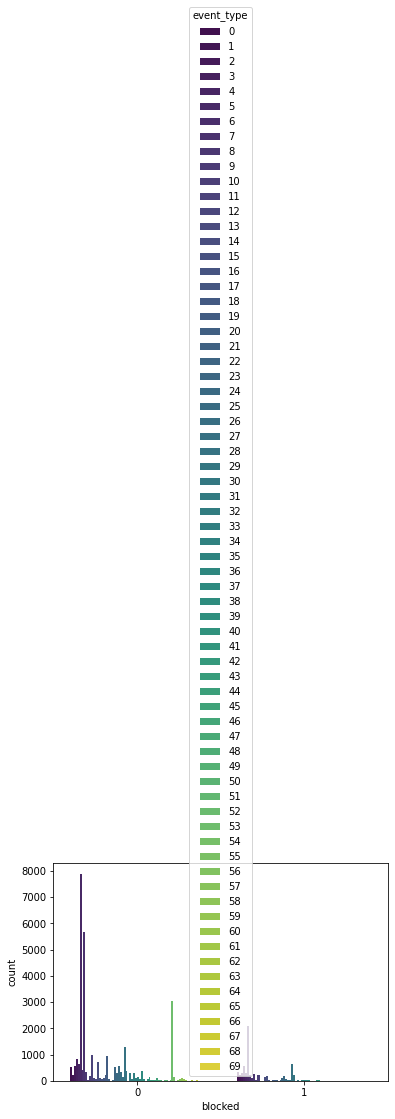

In [11]:
sns.countplot(x='blocked',data=datas_copy, hue='event_type',palette='viridis')

Давайте теперь создадим еще одну копию нашего датасета на этом этапе, чтобы позже вернуться к нему, а так же, проверим, корректно ли все на данный момент:

In [12]:
datas_copy2 = datas_copy
datas_copy

,event_type,blocked,name,day_or_month_contract
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,1,1,0,0
4,1,1,0,0
...,...,...,...,...
36801,52,0,0,0
36802,52,0,12,0
36803,52,0,3,0
36804,52,0,0,0


Колонка blocked сообщает, ушел ли пользователь (customer churn);
где 1 - ушел, а 0 - не ушел.
Давайте посмотрим на то, сколько у нас таких пользователей:

In [13]:
#Проверяем значения blocked
datas_copy["blocked"].value_counts()

0    29894
1     6912
Name: blocked, dtype: int64

Заботимся о недостающих данных. Важно проверить статус каждой колонки, они все должны быть non-null (не пустые).

In [14]:
datas_copy.info()
datas_copy.isna().any()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36806 entries, 0 to 36805
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   event_type             36806 non-null  int64
 1   blocked                36806 non-null  int64
 2   name                   36806 non-null  int64
 3   day_or_month_contract  36806 non-null  int64
dtypes: int64(4)
memory usage: 2.7 MB


event_type               False
blocked                  False
name                     False
day_or_month_contract    False
dtype: bool

Колонку со значениями blocked мы удалим из датасета и сохраним в переменной response, чтобы применить отдельно от основных сведениях о клиенте во время обучения. 

In [15]:
response = datas_copy2["blocked"]
dataset = datas_copy2.drop(columns="blocked")

Разобьем наш подготовленный датасет на два: обучающи1 и тестовый наборы данных зависимых и независимых переменных:

In [16]:
X_train, X_test, y_train, y_test = train_test_split(dataset, response,
                                                    stratify=response, #для устранения любого дисбаланса классов - используем параметр stratify
                                                    test_size = 0.2, #используйте 0.9, если данные очень большие (150к+ строк)
                                                    random_state = 0)

print("Number transactions X_train dataset: ", X_train.shape) #количество транзакций X_train набора данных
print("Number transactions y_train dataset: ", y_train.shape) #количество транзакций y_train набора данных
print("Number transactions X_test dataset: ", X_test.shape) #количество транзакций X_test набора данных
print("Number transactions y_test dataset: ", y_test.shape) #количество транзакций y_test набора данных

Number transactions X_train dataset:  (29444, 3)
Number transactions y_train dataset:  (29444,)
Number transactions X_test dataset:  (7362, 3)
Number transactions y_test dataset:  (7362,)


Проведем масштабирование функций: очень важно нормализовать переменные перед выполнением любых алгоритмов машинного обучения (классификации), чтобы все обучающие и тестовые переменные были масштабированы в диапазоне от 0 до 1.

In [17]:
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_train2.columns = X_train.columns.values
X_train2.index = X_train.index.values
X_train = X_train2

X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_test2.columns = X_test.columns.values
X_test2.index = X_test.index.values
X_test = X_test2

# Выбор модели
Сравним базовые алгоритмы классификации (1-я итерация). Давайте смоделируем каждый алгоритм классификации на наборе обучающих данных и оценим их точность и показатели стандартного отклонения.

Точность классификации является одним из наиболее распространенных показателей оценки классификации для сравнения базовых алгоритмов, так как это количество правильных прогнозов, сделанных как отношение к общему количеству прогнозов. Однако это не идеальная метрика, когда у нас есть проблема дисбаланса классов. Следовательно, давайте отсортируем результаты на основе значения «среднего AUC», которое представляет собой не что иное, как способность модели различать положительные и отрицательные классы.

Ps: если выберем подходящий алгоритм, то получим и высокую точность конечной модели:)

In [18]:
models = []
models.append(('Logistic Regression', LogisticRegression(solver='liblinear', random_state = 0,
                                                         class_weight='balanced')))

models.append(('SVC', SVC(kernel = 'linear', random_state = 0)))

models.append(('Kernel SVM', SVC(kernel = 'rbf', random_state = 0)))

models.append(('KNN', KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)))

models.append(('Gaussian NB', GaussianNB()))

models.append(('Decision Tree Classifier',
               DecisionTreeClassifier(criterion = 'entropy', random_state = 0)))

models.append(('Random Forest', RandomForestClassifier(
    n_estimators=100, criterion = 'entropy', random_state = 0)))


#Оценим результатов модели:    
acc_results = []
auc_results = []
names = []
#Вставим таблицу в таблицу для заполнения результатами производительности
col = ['Algorithm', 'ROC AUC Mean', 'ROC AUC STD', 
       'Accuracy Mean', 'Accuracy STD']

model_results = pd.DataFrame(columns=col)
i = 0

#Оценим каждую модель, используя k-кратную перекрестную проверку
for name, model in models:
    kfold = model_selection.KFold(
        n_splits=10, shuffle=True, random_state=0)  #10-кратная перекрестная проверка

    cv_acc_results = model_selection.cross_val_score(  #Оценка точности
        model, X_train, y_train, cv=kfold, scoring='accuracy')

    cv_auc_results = model_selection.cross_val_score(  #Определим метрику ROC_AUC 
        model, X_train, y_train, cv=kfold, scoring='roc_auc')

    acc_results.append(cv_acc_results)
    auc_results.append(cv_auc_results)
    names.append(name)
    model_results.loc[i] = [name,
                         round(cv_auc_results.mean()*100, 2),
                         round(cv_auc_results.std()*100, 2),
                         round(cv_acc_results.mean()*100, 2),
                         round(cv_acc_results.std()*100, 2)
                         ]
    i += 1

#сделаем копию результатов (понадобятся в конце), а так же покажем табличку с результатами различных алгоритмов обучения
model_results_backup = model_results
model_results.sort_values(by=['ROC AUC Mean'], ascending=False)

,Algorithm,ROC AUC Mean,ROC AUC STD,Accuracy Mean,Accuracy STD
6,Random Forest,87.05,0.63,88.02,0.48
5,Decision Tree Classifier,86.33,0.70,88.01,0.49
3,KNN,81.76,1.33,85.59,1.98
2,Kernel SVM,80.26,0.93,85.73,0.64
4,Gaussian NB,66.26,0.95,81.22,0.63
0,Logistic Regression,58.87,1.29,51.77,0.75
1,SVC,48.92,5.52,81.22,0.63


Показал себя хорошо алгоритм Kernel SVM, у него лучший результат:) но некоторые другие смотрят ему в спину!)

In [19]:
print("Algorithm: Kernel SVM, \n    ROC AUC:\n        ROC AUC Mean:", model_results.loc[2][1], "\n        ROC AUC STD:", model_results.loc[2][2], "\n    Accuracy:\n        Accuracy Mean:", model_results.loc[2][3], "\n        Accuracy STD:", model_results.loc[2][4]) 

Algorithm: Kernel SVM, 
    ROC AUC:
        ROC AUC Mean: 80.26 
        ROC AUC STD: 0.93 
    Accuracy:
        Accuracy Mean: 85.73 
        Accuracy STD: 0.64


Визуализируем сравнение точности алгоритмов классификации:

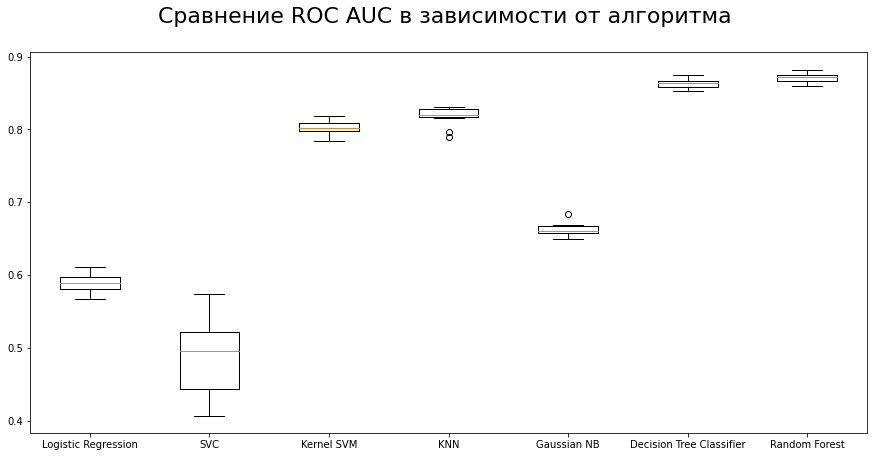

In [20]:
 #using Area under ROC Curve:

fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)
plt.boxplot(auc_results)
ax.set_xticklabels(names)


#plt.ylabel('ROC AUC Score\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
#plt.xlabel('\n Baseline Classification Algorithms\n',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.title('Сравнение ROC AUC в зависимости от алгоритма \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
#plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")


plt.show()

В блоке ниже находится код обучения для различных алгормов, уже более точный, - можно запросто скопировать код для подходящего алгоритма и обучать с ним, но я оставлю здесь код для всех алгоритмов:

In [21]:
#Logistic Regression

#Подгонка Logistic Regression к тренировочному набору:
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

#Прогнозирование результатов набора тестов:
y_pred = classifier.predict(X_test)

#Оценивание результатов:
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)

results = pd.DataFrame([['Logistic Regression', acc, prec, rec, f1, f2]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])


#SVM

#Подгонка SVM (SVC class) к тренировочному набору:
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train, y_train)

#Прогнозирование результатов набора тестов:
y_pred = classifier.predict(X_test)

#Оценивание результатов:
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)

model_results = pd.DataFrame([['SVM (Linear)', acc, prec, rec, f1, f2]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])

results = results.append(model_results, ignore_index = True)


#K-Nearest Neighbours

#Подгонка KNN к тренировочному набору:
classifier = KNeighborsClassifier(n_neighbors = 22, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

#Прогнозирование результатов набора тестов:
y_pred  = classifier.predict(X_test)

#Оценивание результатов:
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)

model_results = pd.DataFrame([['K-Nearest Neighbours', acc, prec, rec, f1, f2]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])

results = results.append(model_results, ignore_index = True)


#Kernel SVM

#Подгонка Kernel SVM к тренировочному набору:
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

#Прогнозирование результатов набора тестов:
y_pred = classifier.predict(X_test)

#Оценивание результатов:
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)

model_results = pd.DataFrame([['Kernel SVM', acc, prec, rec, f1, f2]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])

results = results.append(model_results, ignore_index = True)


#Naive Byes

#Подгонка Naive Byes (GaussianNB) к тренировочному набору:
classifier = GaussianNB()
classifier.fit(X_train, y_train)

#Прогнозирование результатов набора тестов:
y_pred = classifier.predict(X_test)

#Оценивание результатов:
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)

model_results = pd.DataFrame([['Naive Byes', acc, prec, rec, f1, f2]],
                columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])

results = results.append(model_results, ignore_index = True)


#Decision Tree

#Подгонка Decision Tree к тренировочному набору:
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

#Прогнозирование результатов набора тестов:
y_pred = classifier.predict(X_test)

#Оценивание результатов:
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)

model_results = pd.DataFrame([['Decision Tree', acc, prec, rec, f1, f2]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])

results = results.append(model_results, ignore_index = True)


#Random Forest

#Подгонка Random Forest к тренировочному набору:
    
classifier = RandomForestClassifier(n_estimators = 72, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

#Прогнозирование результатов набора тестов:
y_pred = classifier.predict(X_test)

#Оценивание результатов:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
acc = accuracy_score(y_test, y_pred )
prec = precision_score(y_test, y_pred )
rec = recall_score(y_test, y_pred )
f1 = f1_score(y_test, y_pred )
f2 = fbeta_score(y_test, y_pred, beta=2.0)

model_results = pd.DataFrame([['Random Forest', acc, prec, rec, f1, f2]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'F2 Score'])

results = results.append(model_results, ignore_index = True)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Визуализируем результаты и сравним базовые алгоритмы:

In [22]:
# =======================================================================================================================
# Сортировка результатов на основе правильной метрики классификации:
# (Accuracy/ROC_AUC / Precision/Recall/F1/F2 scores)

# Так как у нас классовый дисбаланс. Когда мы рассматриваем бизнес-задачи,
# наши ложноотрицательные результаты будут дорогостоящими, и, следовательно, нам нужно следить за точностью, отзывом и F2, помимо точности.
# =======================================================================================================================

results = results.sort_values(["Precision", "Recall", "F2 Score"], ascending = False)
results_library = results
print (results)


                  Model  Accuracy  Precision    Recall  F1 Score  F2 Score
5         Decision Tree  0.876800   0.841954  0.423717  0.563733  0.470456
6         Random Forest  0.876528   0.831933  0.429501  0.566524  0.475504
2  K-Nearest Neighbours  0.868514   0.816794  0.386840  0.525025  0.432358
3            Kernel SVM  0.850992   0.687664  0.378886  0.488578  0.416269
0   Logistic Regression  0.812143   0.000000  0.000000  0.000000  0.000000
1          SVM (Linear)  0.812143   0.000000  0.000000  0.000000  0.000000
4            Naive Byes  0.812143   0.000000  0.000000  0.000000  0.000000


#Окончательная настройка и выбор гиперпараметров

In [23]:
#код для LogisticRegression: lr_classifier = LogisticRegression(random_state = 0, penalty = 'l2')
#код для LogisticRegression: lr_classifier.fit(X_train, y_train)

#код для DecisionTreeClassifier: lr_classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
#код для DecisionTreeClassifier: lr_classifier.fit(X_train, y_train)

lr_classifier = RandomForestClassifier(n_estimators = 72, criterion = 'entropy', random_state = 0)
lr_classifier.fit(X_train, y_train)

#Предсказываем результаты тестового набора:
y_pred = lr_classifier.predict(X_test)

#Показатель вероятности
y_pred_probs = lr_classifier.predict_proba(X_test)
y_pred_probs  = y_pred_probs [:, 1] 

In [24]:
cm = confusion_matrix(y_test, y_pred) 
print (cm)

[[5859  120]
 [ 789  594]]


In [25]:
pd.crosstab(y_test,pd.Series(y_pred),rownames=['ACTUAL'],colnames=['PRED'])

PRED,0,1
ACTUAL,,
0,88,7
1,1256,127


Давайте взглянем на матрицу ошибок (confusion_matrix):

Test Data Accuracy: 0.8765


<Figure size 2016x1440 with 0 Axes>

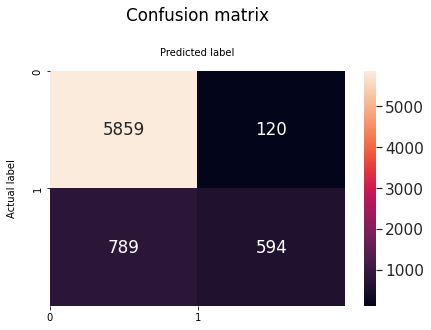

In [26]:
cm = confusion_matrix(y_test, y_pred) 
df_cm = pd.DataFrame(cm, index = (0, 1), columns = (0, 1))
plt.figure(figsize = (28,20))


fig, ax = plt.subplots()
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g'#,cmap="YlGnBu" 
           )
class_names=[0,1]
tick_marks = np.arange(len(class_names))
plt.tight_layout()
plt.title('Confusion matrix\n', y=1.1)
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
ax.xaxis.set_label_position("top")
plt.ylabel('Actual label\n')
plt.xlabel('Predicted label\n')
print("Test Data Accuracy: %0.4f" % accuracy_score(y_test, y_pred))

#Форматирование данных.
Непредсказуемость и риск — близкие спутники любых прогностических моделей. Поэтому в реальном мире всегда рекомендуется строить оценку склонности помимо абсолютного прогнозируемого результата. Вместо того, чтобы просто получать двоичный оценочный целевой результат (0 или 1), каждый «идентификатор клиента» может получить дополнительный уровень оценки склонности, показывающий процент вероятности совершения целевого действия.

In [27]:
final_results = pd.concat([test_identity, y_test], axis = 1).dropna()

final_results['predictions'] = y_pred 
final_results["propensity_to_convert(%)"] = y_pred_probs 
final_results["propensity_to_convert(%)"] = final_results["propensity_to_convert(%)"]*100
final_results["propensity_to_convert(%)"] = final_results["propensity_to_convert(%)"].round(2)
final_results = final_results[['contract_id', 'blocked', 'predictions', 'propensity_to_convert(%)']]
final_results ['Ranking'] = pd.qcut(final_results['propensity_to_convert(%)'].rank(method = 'first'),10,labels=range(10,0,-1))
#print (final_results)

#Сохраним обученную модель
Наконец-то.. два дня, и, получилось! Давайте сохраним модель локально в файловом хранилище.

In [28]:
filename = 'final_model.model'
i = [lr_classifier]
joblib.dump(i,filename)

['final_model.model']

#Сохраним другие материалы
Некоторые другие материалы, возможно, пригодятся при предсказывании:

In [36]:
final_results.to_csv("datas/final_results.csv", encoding='utf-8')

#Теперь предскажем
Ранее мы оставляли таблицу datas_copy, и работали с ее копией. Теперь время снова вернуться к ней.
Создадим ее копию datas_predictionstable, и будем работать с ней. Из datas_predictionstable мы получим сведения о клиенте, и по ним будем предсказывать поведение каждого конкретного пользователя для дальнейшей записи итогов предсказания в test.csv

Сделаем копию таблицы datas_copy, назовем копию datas_predictionstable. Из datas_predictionstable удалим колонку blocked, чтобы не читарить (если на самом деле, то наша обученная модель не ожидает этот параметр, поэтому он не нужен нам здесь).

In [40]:
datas_predictionstable = datas_copy
datas_predictionstable = datas_predictionstable.drop(columns=['blocked'])
datas_predictionstable.to_csv("datas/datas_predictionstable.csv", encoding='utf-8')
datas_predictionstable

,event_type,name,day_or_month_contract
0,0,0,0
1,0,0,0
2,0,0,0
3,1,0,0
4,1,0,0
...,...,...,...
36801,52,0,0
36802,52,12,0
36803,52,3,0
36804,52,0,0


Вывыдем предсказания, чтобы убедиться, что здесь у нас все.. хотябы, работает:

In [30]:
yPred = lr_classifier.predict(datas_predictionstable)
print(yPred)

[1 1 1 ... 0 0 0]


Теперь получим файл test.csv, куда нам по заданию хакатона и нужно вписать, уйдет клиент, или нет:

In [31]:
test0=pd.read_csv('datas/test.csv')
test0

,contract_id,blocked
0,1034,NaN
1,1074,NaN
2,1145,NaN
3,1261,NaN
4,1315,NaN
...,...,...
296,274468,NaN
297,274482,NaN
298,274486,NaN
299,274540,NaN


По тестовому выводу видим, что все загрузилось. В поле contract_id у нас представлены номера договоров, а в поле blocked - пустые значения, их мы и заполним предсказаниями:

In [32]:
count_row = test0.shape[0]
pd.options.mode.chained_assignment
for x in range(test0.shape[0]):
  lookfor = test0.iloc[x].contract_id
  prediction = final_results.loc[final_results['contract_id'] == int(lookfor)]
  test0.at[x, 'blocked'] = int(yPred[x])
test0.blocked = test0.blocked.astype(int)
test0

,contract_id,blocked
0,1034,1
1,1074,1
2,1145,1
3,1261,1
4,1315,1
...,...,...
296,274468,0
297,274482,0
298,274486,0
299,274540,0


Теперь сохраним измененный test.csv туда же, откуда мы его взяли (то есть, попросту перезапишем):

In [33]:
test0.to_csv("datas/test.csv", encoding='utf-8')

Точность нашей модели согласно алгоритму обучения, который мы выбрали:

In [57]:
bold = "\033[1m"
results_library.loc[6]

Model        Random Forest
Accuracy          0.876528
Precision         0.831933
Recall            0.429501
F1 Score          0.566524
F2 Score          0.475504
Name: 6, dtype: object



Точность по метрике F1 SCORE: 0.6




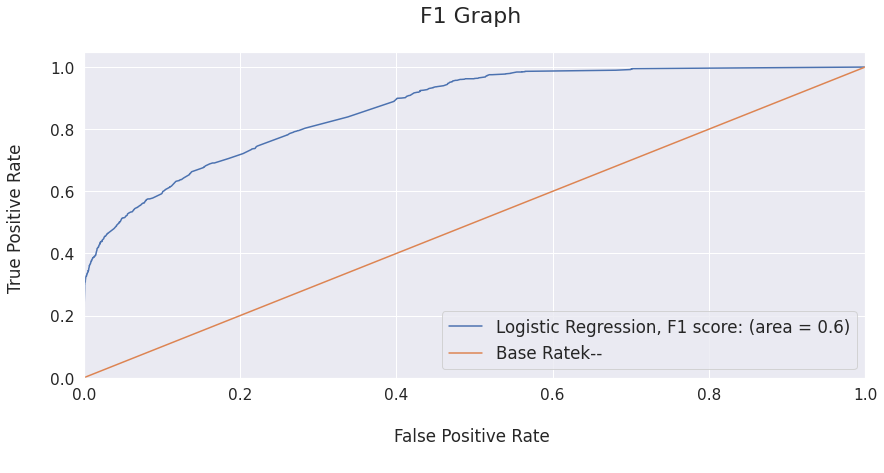

In [58]:
#Оценим модель с помощью графика ROC

from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

classifier.fit(X_train, y_train) 
probs = classifier.predict_proba(X_test) 
probs = probs[:, 1] 
classifier_f1_score = f1_score(y_test, y_pred )

rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:,1])
plt.figure(figsize=(14, 6))

#Построим логистическую регрессию ROC
plt.plot(rf_fpr, rf_tpr, label='Logistic Regression, F1 score: (area = %0.1f)' % classifier_f1_score)

#Построим Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.ylabel('True Positive Rate \n',horizontalalignment="center",fontstyle = "normal", fontsize = "medium", fontfamily = "sans-serif")
plt.xlabel('\nFalse Positive Rate \n',horizontalalignment="center",fontstyle = "normal", fontsize = "medium", fontfamily = "sans-serif")
plt.title('F1 Graph \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
plt.legend(loc="lower right", fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")

print('\n\nТочность по метрике F1 SCORE: %0.1f\n\n' % classifier_f1_score)

Сохраним модель для скрипта, который уже будет предсказывать, чтобы каждый раз не приходилось обучать модель сначала:

In [43]:
import pickle

with open("model_complete.pkl", "wb") as f:
    pickle.dump(lr_classifier, f)